In [1]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def select_func(x):
    if isinstance(x, list):
        return x[0]
    elif isinstance(x, dict):
        return x.get('correctness', 'failed')
    else:
        return x

#### Extract model performance

In [3]:
model_performance = []
for file in os.listdir('Results'):
    if file.endswith('.json'):
        model = file.split('_')[0]
        problem = file.split('_')[1].split('.')[0]
        with open('Results/' + file) as f:
            correct = []
            for line in f.readlines()[-1:]:
                data = json.loads(line)
                correct.extend([select_func(x.get('correctness', 'failed')) for x in data])
            performance = {
                'model': model,
                'problem': problem,
                'correct': correct
            }
            model_performance.append(performance)

#### Calculate model accuracy

In [4]:
def calculate_accuracy(expr_result):
    model_name = expr_result['model']
    problem_name = expr_result['problem']
    correct = expr_result['correct']
    assert len(correct) == 100, f'Incorrect number of results for {model_name} on {problem_name} with {len(correct)} results'
    level_correctness = [correct[i:i+10] for i in range(0, len(correct), 10)]
    filter_failed = lambda x: [y for y in x if y != 'failed']
    level_correctness = [filter_failed(x) for x in level_correctness]
    
    failed_expr = [10 - len(x) for x in level_correctness]
    failed_num = sum(failed_expr)
    if failed_num > 0:
        print(f'{model_name} on {problem_name} has {failed_num} failed results')
    level_accuracy = []
    for x in level_correctness:
        if len(x) == 0:
            level_accuracy.append(0)
        else:
            level_accuracy.append(sum(x) / 10)
    return {
        'model': model_name,
        'problem': problem_name,
        'accuracy': level_accuracy,
        'failed': failed_expr
    }

#### Export to a csv file

In [5]:
result_df = []
for expr_result in model_performance:
    result = calculate_accuracy(expr_result)
    expr_df = pd.DataFrame(columns=['model', 'problem', 'level', 'Average accuracy', 'Failed'])
    model_name = result['model']
    problem_name = result['problem']
    accuracy = result['accuracy']
    failed = result['failed']

    expr_df['model'] = [model_name] * 10
    expr_df['problem'] = [problem_name] * 10
    expr_df['level'] = [f'Lvl {i+1}' for i in range(10)]
    expr_df['Average accuracy'] = accuracy
    expr_df['Failed'] = failed
    result_df.append(expr_df)

result_df = pd.concat(result_df)

mistral on mspResults has 80 failed results
gpt-4-1106-preview on tspResults has 1 failed results
claude-2 on mspResults has 4 failed results
claude-instant-1.2 on mspResults has 5 failed results
phi on mspResults has 99 failed results
claude-2 on tspResults has 11 failed results
gpt-4-1106-preview on mspResults has 10 failed results
claude-instant-1.2 on gcpResults has 1 failed results
gpt-3.5-turbo on tspResults has 1 failed results
claude-2 on gcpResults has 1 failed results
claude-instant-1.2 on tspResults has 3 failed results


#### Basic setup

In [6]:
result_df.model.unique()

array(['vicuna', 'mistral', 'gpt-4-1106-preview', 'claude-2', 'mpt',
       'claude-instant-1.2', 'gpt-3.5-turbo', 'yi', 'phi'], dtype=object)

In [7]:
close_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo', 'claude-2', 'claude-instant-1.2']

open_model_df = result_df[~result_df['model'].isin(close_models)]
close_model_df = result_df[result_df['model'].isin(close_models)]

problem_set = result_df['problem'].unique()

In [8]:
def plot_figure(problem_set, y_name, result_df, prefix=''):
    for problem in problem_set:
        plt.figure(figsize=(10, 5))
        data = result_df[result_df['problem'] == problem]
        if len(data) == 0:
            continue
        sns.lineplot(x='level', y=y_name, hue='model', data=data)
        # sns.barplot(x='level', y=y_name, hue='model', data=data)
        plt.title(f'{y_name} on {problem}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(f'./figures/{prefix}_{problem}_{y_name}.png', bbox_inches='tight', dpi=150)

##### Open models

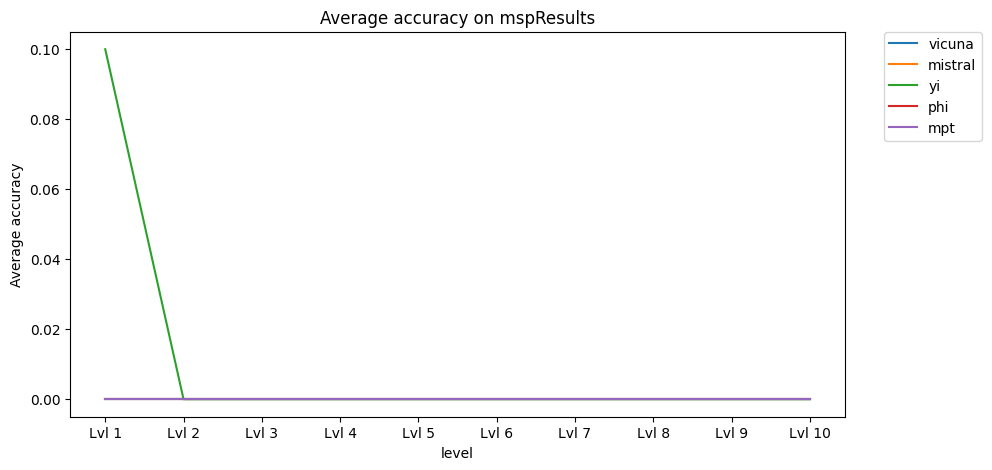

<Figure size 1000x500 with 0 Axes>

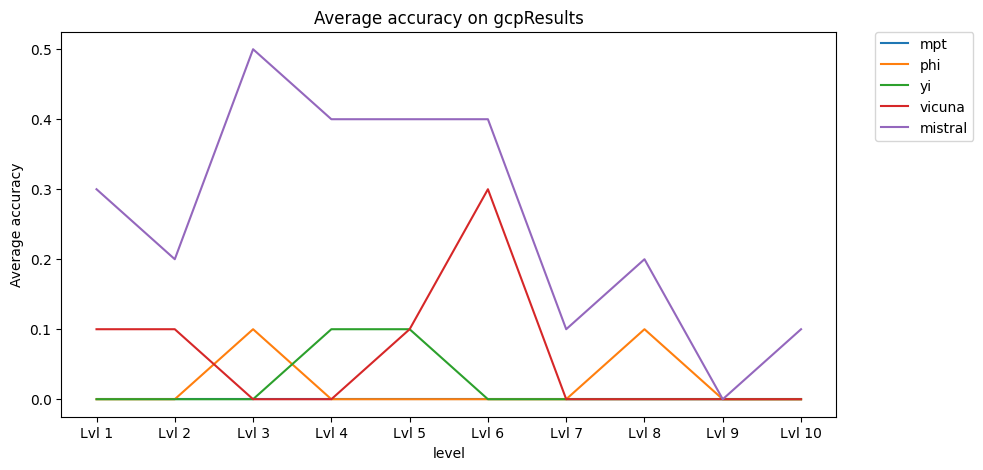

In [9]:
plot_figure(problem_set, 'Average accuracy', open_model_df, prefix='open')

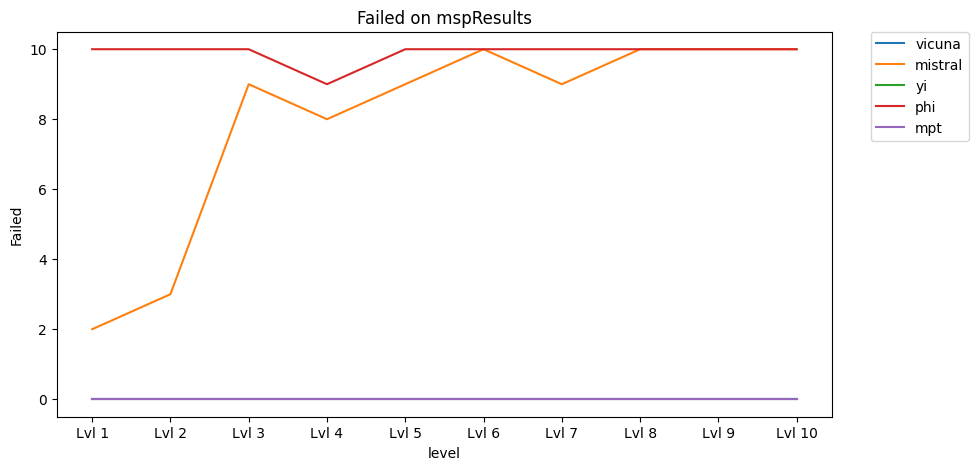

<Figure size 1000x500 with 0 Axes>

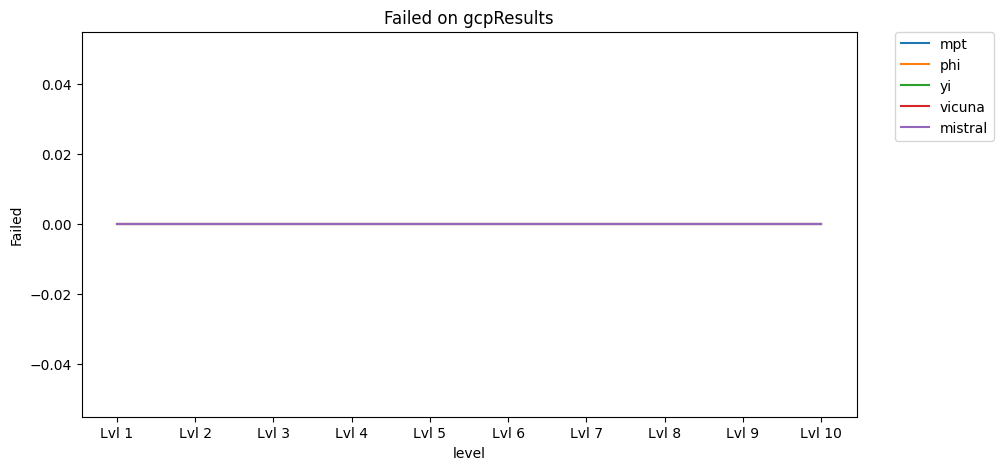

In [10]:
plot_figure(problem_set, 'Failed', open_model_df, prefix='open')

##### Close models

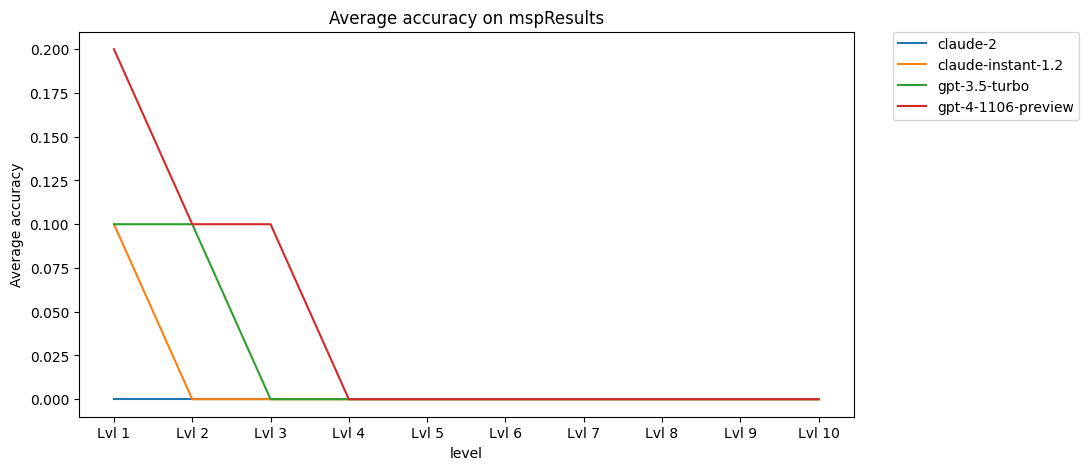

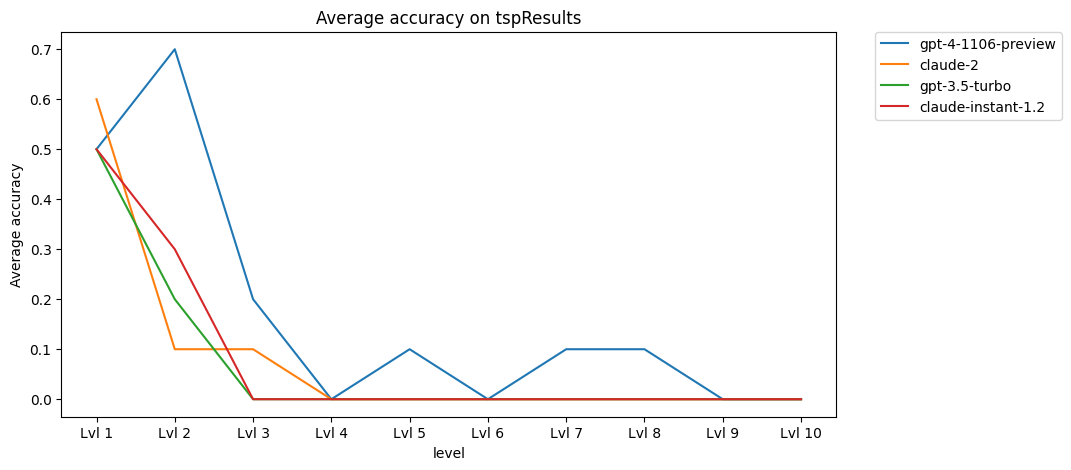

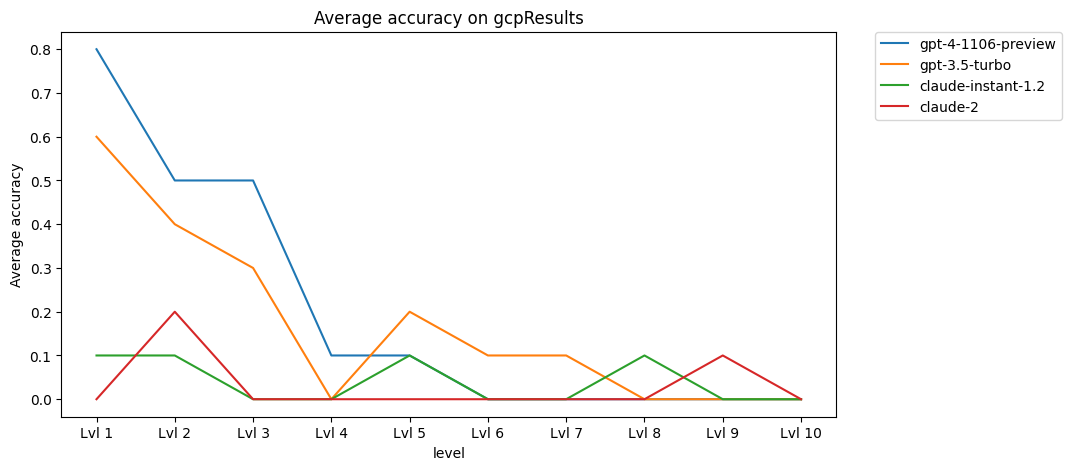

In [11]:
plot_figure(problem_set, 'Average accuracy', close_model_df, prefix='close')

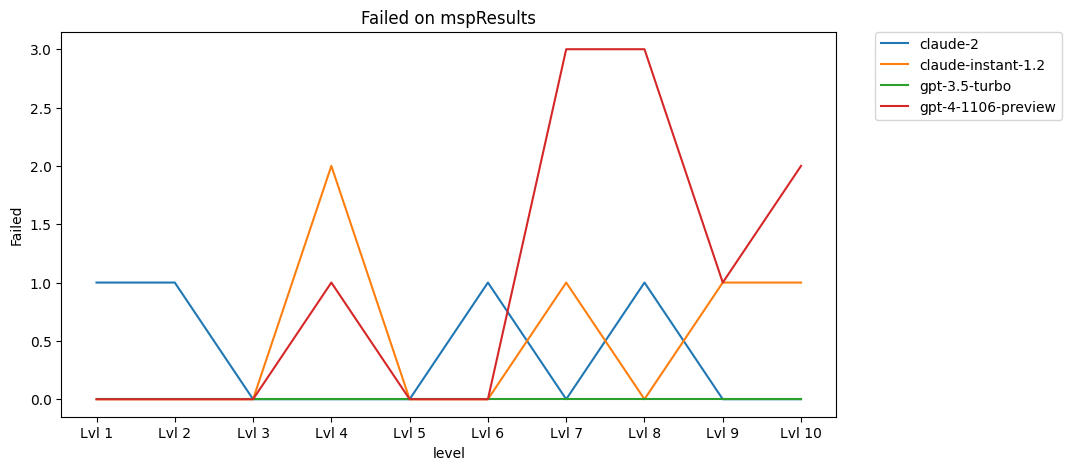

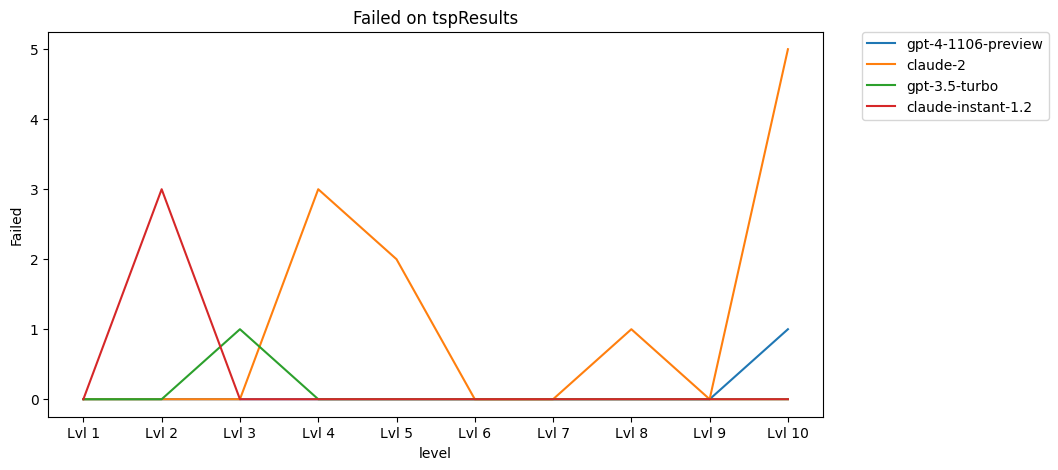

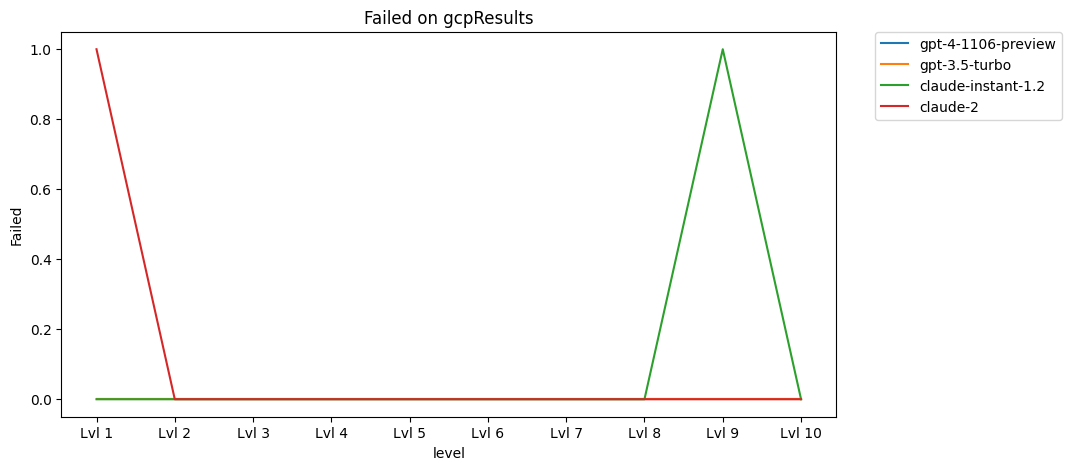

In [12]:
plot_figure(problem_set, 'Failed', close_model_df, prefix='close')

#### Save to csv file

In [13]:
result_df.to_csv('results.csv', index=False)